(torch.Size([20]), torch.Size([20]))

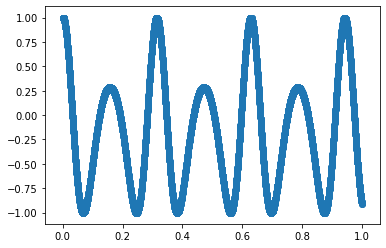

In [96]:
import torch
import matplotlib.pyplot as plt
from fastai2.data.all import *
from fastai2.callback.all import *
from fastai2.learner import Learner
from fastai2.optimizer import SGD

x = torch.rand(10000) 

y = torch.cos(5*torch.sin(10*x))


plt.scatter(x,y)

db = DataBlock(get_x = lambda x:x[0], get_y=lambda x:x[1])

data = torch.stack((x,y),dim=1)
data.shape

dls  =db.dataloaders(data,bs=20)

bx, by = dls.one_batch()

bx.shape, by.shape

In [16]:
def gen_w(steps):
    L = [1.]+[-1.,-1.,1.,1.] * ((steps +3) //4)
    return torch.tensor(L[:steps]) # * steps

class MyModel(torch.nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        
        self.W1 = torch.nn.Parameter(torch.ones(hidden_size))
        self.W2 = torch.nn.Parameter(gen_w(hidden_size))
        #self.W_scale = torch.nn.Parameter(torch.tensor([float(hidden_size)]))
        self.B1 =  torch.nn.Parameter(-torch.linspace(0,1, hidden_size))
        self.B2 = torch.nn.Parameter(torch.tensor([0.]))
        '''
        self.l1 = nn.Linear(1, hidden_size)
        self.l2 = nn.Linear(hidden_size, 1)
        '''
    def forward(self, x):
        y1 = F.relu(self.W1 * x[:,None] + self.B1)
        #res = torch.sum(self.W_scale *self.W2 * y1, dim = 1) + self.B2
        res = torch.sum(self.W2 * y1, dim = 1) + self.B2
        #res = self.l2(F.relu(self.l1(x[:,None])))
        return res.squeeze()

In [17]:
class ShowChart(Callback):
    
    def __init__(self, dx, dy, figsize=(10,4)):
        self.figsize = figsize
        self.dx = dx
        self.dy = dy
    def after_validate(self):
        self.update_graph()
    
    def update_graph(self):
        if not hasattr(self, 'graph_ax'):
            graph_fig, self.graph_ax = plt.subplots(1, figsize=self.figsize)
            plt.close()
            self.graph_out = display(self.graph_ax.figure, display_id=True)
        model = self.learn.model
        prediction = model(self.dx.cuda()).cpu().detach()
  

        self.graph_ax.clear()
        self.graph_ax.set_ylim(-1.5,1.5)
        self.graph_ax.scatter(self.dx, self.dy, label='actual')
        self.graph_ax.scatter(self.dx,prediction, label = 'pred')
        self.graph_ax.legend(loc='lower left');
        self.graph_out.update(self.graph_ax.figure)
       

In [26]:
mm = MyModel(4)
learn = Learner(dls,mm, loss_func=nn.MSELoss() , cbs = ShowChart(x,y))

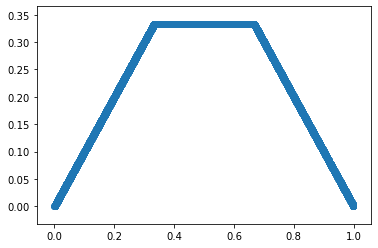

In [27]:
plt.scatter(x, mm(x.cuda()).detach().cpu())

In [32]:
opt = torch.optim.SGD(mm.parameters(), lr=.1)

for epoch in range(40):
    tot_loss = 0
    steps =0
    for bx, by in dls.train:
        res = mm(bx)
        loss = F.mse_loss(res, by)
        loss.backward()
        opt.step()
        opt.zero_grad()
        tot_loss += loss
        steps += 1
    print(epoch, tot_loss / steps)


0 tensor(0.2846, device='cuda:0', grad_fn=<DivBackward0>)
1 tensor(0.2837, device='cuda:0', grad_fn=<DivBackward0>)
2 tensor(0.2828, device='cuda:0', grad_fn=<DivBackward0>)
3 tensor(0.2819, device='cuda:0', grad_fn=<DivBackward0>)
4 tensor(0.2810, device='cuda:0', grad_fn=<DivBackward0>)
5 tensor(0.2800, device='cuda:0', grad_fn=<DivBackward0>)
6 tensor(0.2791, device='cuda:0', grad_fn=<DivBackward0>)
7 tensor(0.2780, device='cuda:0', grad_fn=<DivBackward0>)
8 tensor(0.2770, device='cuda:0', grad_fn=<DivBackward0>)
9 tensor(0.2761, device='cuda:0', grad_fn=<DivBackward0>)
10 tensor(0.2751, device='cuda:0', grad_fn=<DivBackward0>)
11 tensor(0.2738, device='cuda:0', grad_fn=<DivBackward0>)
12 tensor(0.2728, device='cuda:0', grad_fn=<DivBackward0>)
13 tensor(0.2717, device='cuda:0', grad_fn=<DivBackward0>)
14 tensor(0.2708, device='cuda:0', grad_fn=<DivBackward0>)
15 tensor(0.2696, device='cuda:0', grad_fn=<DivBackward0>)
16 tensor(0.2686, device='cuda:0', grad_fn=<DivBackward0>)
17 tens

In [22]:
learn.fit_one_cycle(10, lr_max=1e-2 )

epoch,train_loss,valid_loss,time
0,0.269278,0.247932,00:05
1,0.341437,0.313887,00:05
2,0.309068,0.306547,00:05
3,0.315624,0.287181,00:05
4,0.343980,0.282838,00:05
5,0.330650,0.403414,00:05
6,0.329571,0.429200,00:05
7,0.296959,0.281911,00:05
8,0.282350,0.283250,00:05
9,0.285710,0.282075,00:05


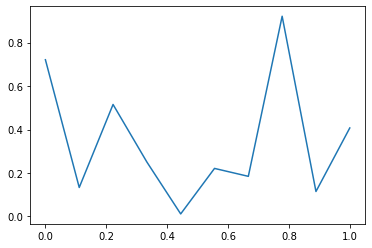

In [92]:
w = torch.linspace(0,1,10)
h = torch.rand(10)
plt.plot(w,h)

In [94]:
def val(x, w,h):
    res = 0
    for i in range(len(w)-1):
        if x >= w[i] and x <=w[i+1]:
            p = (x - w[i]) / (w[i+1] - w[i])
            res += h[i] + p * (h[i+1]-h[i])
    return res    

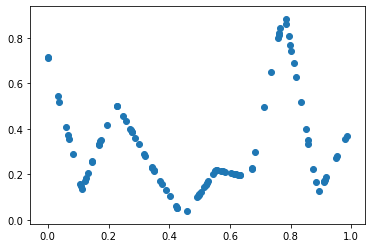

In [105]:
plt.scatter(x,rx)

In [86]:
class BarModule(torch.nn.Module):
    def __init__(self, n):
        super().__init__()
        self.c = nn.Parameter(torch.linspace(0,1,n))
        self.h = nn.Parameter(torch.ones(n))
        self.w = nn.Parameter(torch.ones(n))
    def forward(self, x):
        res = 0
        for i in range(len(self.c)):
            res += br(x,self.c[i],self.w[i],self.h[i])
        return res   

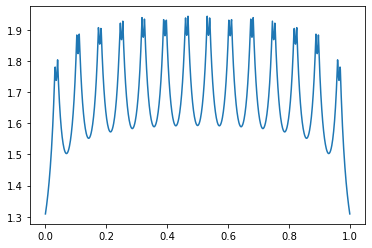

In [110]:
bm = BarModule(15)
bx = torch.linspace(0,1,1000)
plt.plot(bx, bm(bx).detach())

In [152]:
def br(x, c,w, h):
    dist = torch.abs(x-c)
    r = 2 * h * ( 1 - 2 * dist / w)
    return r.clamp(0,h)

def baricade(x,n,h):
    c = torch.linspace(0,1,n)
    d = 1/(n-1)
    w = 4 * d / 3
    res =0
    print(c)
    print(w)
    for i in range(n):
        res += br(x, c[i], w, h)
    return res

#bx = torch.linspace(0,1,1000)
#by = torch.tensor([baricade(x,10,1) for x in bx])
#plt.plot(bx, by)
baricade(.5, 10, 1)

tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000])
0.14814814814814814


tensor(1.0000)

In [150]:
baricade(0,10, 1)

0.1111111111111111

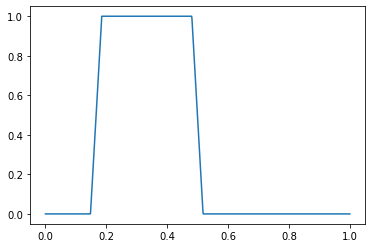

In [157]:
bx = torch.linspace(0,1,1000)
by = torch.tensor([br(x, 0.222,.148,1)+br(x, 0.333,.148,1)+br(x, 0.444,.148,1) for x in bx])
plt.plot(bx, by)

In [98]:
learn = Learner(dls,bm, loss_func=nn.MSELoss() , cbs = ShowChart(x,y))

SuggestedLRs(lr_min=0.33113112449646, lr_steep=0.2089296132326126)

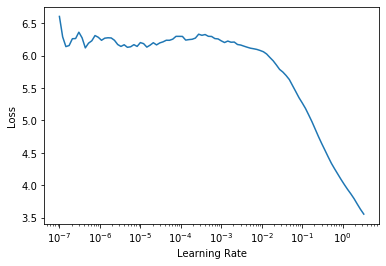

In [99]:
learn.lr_find()

epoch,train_loss,valid_loss,time
0,0.287942,0.214786,00:13
1,0.346232,0.330993,00:13
2,0.366515,0.428267,00:13
3,0.353158,0.352677,00:13
4,0.367564,0.367453,00:13
5,0.367931,0.348932,00:13
6,0.329144,0.364519,00:13
7,0.308287,0.322960,00:13
8,0.292809,0.297230,00:13
9,0.301275,0.294062,00:13


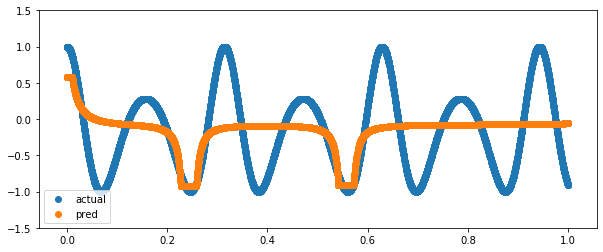

In [100]:
learn.fit_one_cycle(10, lr_max=1e-1 )